In [20]:
from sim_tools import *
from classy import Class
import MAS_library as MASL
import Pk_library as PKL

In [12]:
with open('../Modes/potential_G.dat', 'r') as f :
    num_read = np.fromfile(f, np.uint32, 1)[0]
    modes = np.fromfile(f, np.complex128, int(num_read / 2))

In [13]:
modes

array([0.00000000e+00+0.00000000e+00j, 6.78608762e-06-4.15528024e-22j,
       2.39924429e-06-1.46911342e-22j, ...,
       1.38951264e-08-8.50831105e-25j, 1.35657731e-08-8.30664028e-25j,
       0.00000000e+00+0.00000000e+00j])

In [14]:
ns = 9.49900000e-01
ngrid = 128

In [15]:
potG =  np.array(np.reshape(load_file('../Meshes/G/potential_G.dat', 1, np.float64), (ngrid, ngrid, ngrid)), dtype = np.float32)

In [16]:
potLC =  np.array(np.reshape(load_file('../Meshes/LC/potential_NG_LC.dat', 1, np.float64), (ngrid, ngrid, ngrid)), dtype = np.float32)

In [17]:
potEQ =  np.array(np.reshape(load_file('../Meshes/EQ/potential_NG_EQ.dat', 1, np.float64), (ngrid, ngrid, ngrid)), dtype = np.float32)

In [18]:
potOR =  np.array(np.reshape(load_file('../Meshes/OR/potential_NG_OR.dat', 1, np.float64), (ngrid, ngrid, ngrid)), dtype = np.float32)

In [21]:
PkG = PKL.Pk(potG, 1.e3, axis = 0, MAS = 'None', threads = 28, verbose = True)
kG       = PkG.k3D
PkG0     = PkG.Pk[:,0] #monopole
NmodesG  = PkG.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 0.09
Time taken = 0.09 seconds


In [22]:
PkLC = PKL.Pk(potLC, 1.e3, axis = 0, MAS = 'None', threads = 28, verbose = True)
kLC       = PkLC.k3D
PkLC0     = PkLC.Pk[:,0] #monopole
NmodeLC  = PkLC.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 0.09
Time taken = 0.09 seconds


In [23]:
PkEQ = PKL.Pk(potEQ, 1.e3, axis = 0, MAS = 'None', threads = 28, verbose = True)
kEQ       = PkEQ.k3D
PkEQ0     = PkEQ.Pk[:,0] #monopole
NmodeEQ  = PkEQ.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 0.09
Time taken = 0.10 seconds


In [24]:
PkOR = PKL.Pk(potOR, 1.e3, axis = 0, MAS = 'None', threads = 28, verbose = True)
kOR       = PkOR.k3D
PkOR0     = PkOR.Pk[:,0] #monopole
NmodeOR  = PkOR.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 0.09
Time taken = 0.09 seconds


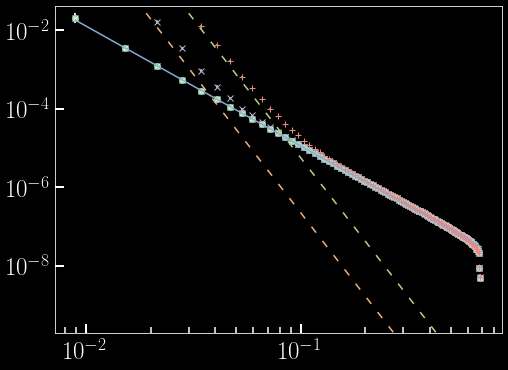

In [42]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.errorbar(kG, PkG0, PkG0 / np.sqrt(NmodesG), ls = 'none', marker = 'o');
ax.errorbar(kLC, PkLC0, PkLC0 / np.sqrt(NmodeLC), ls = 'none', marker = 'x');
ax.errorbar(kEQ, PkEQ0, PkEQ0 / np.sqrt(NmodeOR), ls = 'none', marker = 'x');
ax.errorbar(kOR, PkOR0, PkOR0 / np.sqrt(NmodeEQ), ls = 'none', marker = '+');
kk = np.logspace(np.log10(np.min(kG)), np.log10(np.max(kG)))
ax.plot(kk, kk**(ns - 4) * 1.e-8, zorder = 5)
ax.plot(kk, kk**(ns - 8) * 2.e-14, zorder = 5, dashes = (5, 7))
ax.plot(kk, kk**(ns - 8) * 5.e-13, zorder = 5, dashes = (5, 7))
ax.set_ylim(2.e-10, 4.e-2);

In [39]:
1.e-8 ** 2. * 200.

2.0000000000000003e-14

In [252]:
theta = np.linspace(0., np.pi, 64)
BG = PKL.Bk(potG, 1.e3, 4.e-1, 3.e-1, theta, 'None', threads = 28)
BkG = BG.B     #bispectrum
QkG = BG.Q     #reduced bispectrum
k3G  = BG.k     #k-bins for power spectrum
Pk3G = BG.Pk    #power spectrum


Computing bispectrum of the field...
Time to compute bispectrum = 2.60


In [261]:
BLC = PKL.Bk(potLC, 1.e3, 4.e-1, 3.e-1, theta, 'None', threads = 28)
BkLC = BLC.B     #bispectrum
QkLC = BLC.Q     #reduced bispectrum
k3LC  = BLC.k     #k-bins for power spectrum
Pk3LC = BLC.Pk    #power spectrum
tcount = BLC.triangles


Computing bispectrum of the field...
Time to compute bispectrum = 2.50


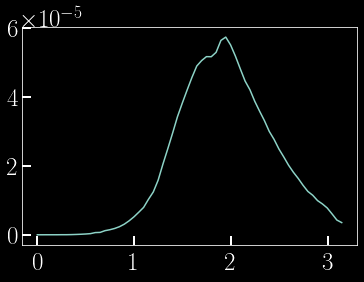

In [262]:
plt.plot(theta, tcount)

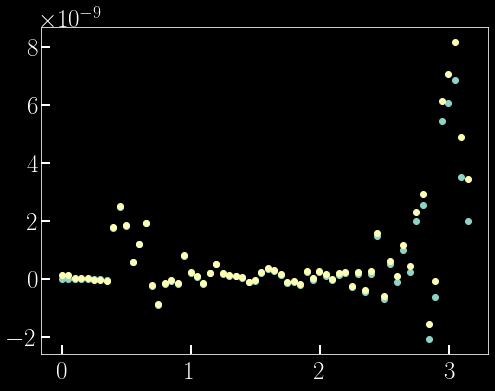

In [254]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(theta, BkG, ls = 'none', marker = 'o');
ax.errorbar(theta, BkLC, ls = 'none', marker = 'o');

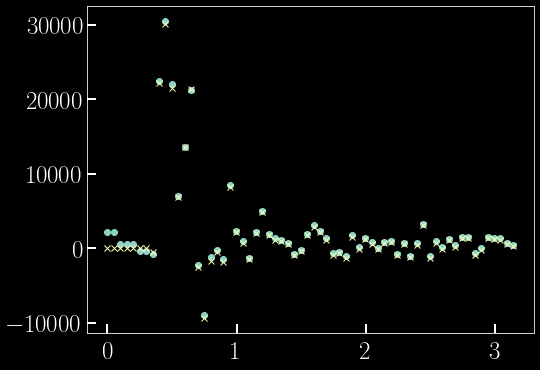

In [255]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(theta, QkLC, ls = 'none', marker = 'o');
ax.errorbar(theta, QkG, ls = 'none', marker = 'x');

#ax.axhline(200.);

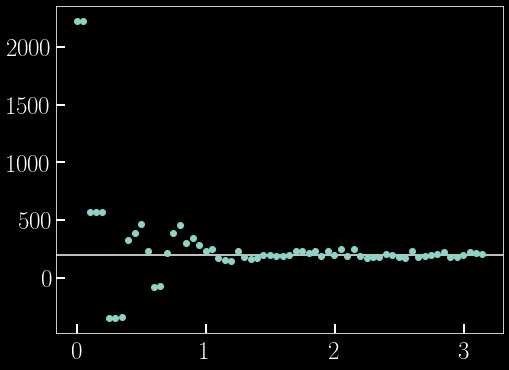

In [256]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(theta, QkLC - QkG, ls = 'none', marker = 'o');
ax.axhline(200.);

In [3]:
kk = np.logspace(-5, 2, 1024)
pp = np.array([cls.pk(tk * cls.h(), 0.) * cls.h() ** 3 for tk in kk])
TT = np.sqrt(pp/pp[0]*(kk[0]/kk)**ns)
D = 0.7789
H0 = 1./3.e3
pp_B = pp * (3 * Om * H0**2 / 2. / D / TT / kk ** 2)**2

In [4]:
def plotSinlgeQ(fn, nm1d, lb, k1, k2, nthread = 28) :    
    mesh = np.array(np.reshape(load_file(fn, 1, np.float64), (nm1d, nm1d, nm1d)), dtype = np.float32)
    theta   = np.linspace(0, np.pi, 16) #array with the angles between k1 and k2
    B = PKL.Bk(mesh, lb, k1, k2, theta, 'None', nthread)
    Bk = B.B     #bispectrum
    Qk = B.Q     #reduced bispectrum
    k  = B.k     #k-bins for power spectrum
    Pk = B.Pk    #power spectrum
    return theta, k, Bk, Qk, Pk

In [5]:
logP_B = interp1d(np.log(kk), np.log(pp_B), kind = 3)

def P_B(k) :
    return k**-4 * np.exp(logP_B(np.log(k)))

def QEQ_B(fNL, k1, k2, theta) :
    k3 = np.sqrt(k1 ** 2 + k2 ** 2 + 2. * k1 * k2 * np.cos(theta))
    P1 = P_B(k1)
    P2 = P_B(k2)
    P3 = P_B(k3)
    D = (P1 * P2 + P2 * P3 + P3 * P1)
    A = ((P1 * P2 * P3) ** (2. / 3.)) / D
    B = (P1 **(1./3.) * P2 ** (2./3.) * P3 + P2 **(1./3.) * P3 ** (2./3.) * P1 + P3 **(1./3.) * P1 ** (2./3.) * P2) / D
    return -6. * fNL * (1. + 2. * A - B)

def QOR_B(fNL, k1, k2, theta) :
    k3 = np.sqrt(k1 ** 2 + k2 ** 2 + 2. * k1 * k2 * np.cos(theta))
    P1 = P_B(k1)
    P2 = P_B(k2)
    P3 = P_B(k3)
    D = (P1 * P2 + P2 * P3 + P3 * P1)
    A = ((P1 * P2 * P3) ** (2. / 3.)) / D
    B = (P1 **(1./3.) * P2 ** (2./3.) * P3 + P2 **(1./3.) * P3 ** (2./3.) * P1 + P3 **(1./3.) * P1 ** (2./3.) * P2) / D
    return -6. * fNL * (3. + 8. * A - 3. * B)

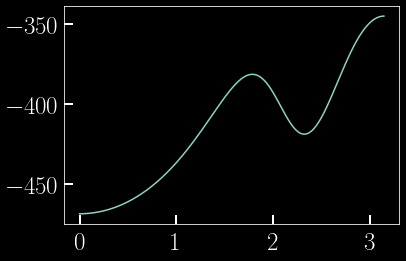

In [18]:
ang = np.linspace(0., np.pi, 128)
plt.plot(ang, QEQ_B(100., 0.2, 0.15, ang))

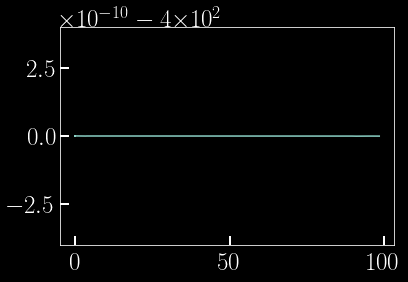

In [32]:
plt.plot(kk[1:-1], QEQ_B(100., kk[1:-1], kk[1:-1], 2. * np.pi / 3.))

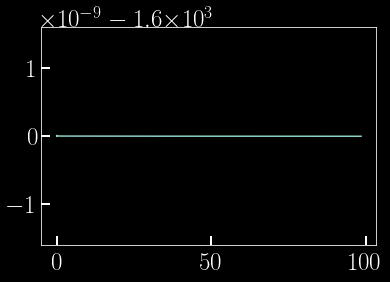

In [33]:
plt.plot(kk[1:-1], QOR_B(100., kk[1:-1], kk[1:-1], 2. * np.pi / 3.))

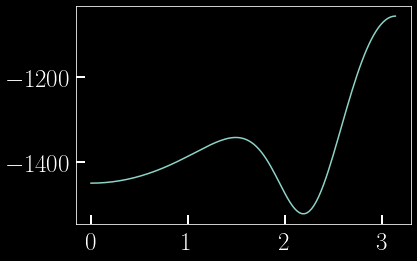

In [19]:
ang = np.linspace(0., np.pi, 128)
plt.plot(ang, QOR_B(100., 0.2, 0.15, ang))

In [20]:
angLC, dqLC, edqLC, kLC = load_file('lc.dat', 4)
angEQ, dqEQ, edqEQ, kEQ = load_file('eq.dat', 4)
angOR, dqOR, edqOR, kOR = load_file('or.dat', 4)

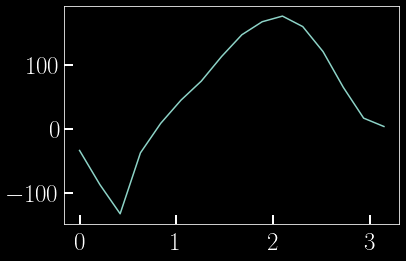

In [22]:
plt.plot(angEQ, dqEQ);

In [54]:
def plotQ(fn, num, lb, nm1d, k1, k2, nthread = 28) :
    theta = np.linspace(0, np.pi, 16) #array with the angles between k1 and k2
    Bks, Qks, Pks = [], [], []
    for i in range(num) :
        mesh = np.array(np.reshape(load_file('%s_%d.dat' % (fn, i), 1, np.float64), (nm1d, nm1d, nm1d)), dtype = np.float32)
        # compute bispectrum
        B = PKL.Bk(mesh, lb, k1, k2, theta, 'None', nthread);
        Bks.append(B.B)     #bispectrum
        Qks.append(B.Q)     #reduced bispectrum
        k  = B.k     #k-bins for power spectrum
        Pks.append(B.Pk)    #power spectrum
    return theta, k, np.array(Bks), np.array(Qks), np.array(Pks)

In [55]:
angLC, kLC, BsLC, QsLC, PsLC = plotQ('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/Meshes/LC/roman_bp_NG', 100, 2.e3, 128, 0.2, 0.15, 40)
angEQ, kEQ, BsEQ, QsEQ, PsEQ = plotQ('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/Meshes/EQ/roman_bp_NG', 100, 2.e3, 128, 0.2, 0.15, 40)
angOR, kOR, BsOR, QsOR, PsOR = plotQ('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/Meshes/OR/roman_bp_NG', 100, 2.e3, 128, 0.2, 0.15, 40)
angRG, kRG, BsG, QsG, PsG = plotQ('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/Meshes/G/roman_bp_G',   100, 2.e3, 128, 0.2, 0.15, 40)


Computing bispectrum of the field...
Time to compute bispectrum = 0.62

Computing bispectrum of the field...
Time to compute bispectrum = 0.63

Computing bispectrum of the field...
Time to compute bispectrum = 0.62

Computing bispectrum of the field...
Time to compute bispectrum = 0.63

Computing bispectrum of the field...
Time to compute bispectrum = 0.62

Computing bispectrum of the field...
Time to compute bispectrum = 0.61

Computing bispectrum of the field...
Time to compute bispectrum = 0.61

Computing bispectrum of the field...
Time to compute bispectrum = 0.62

Computing bispectrum of the field...
Time to compute bispectrum = 0.65

Computing bispectrum of the field...
Time to compute bispectrum = 0.62

Computing bispectrum of the field...
Time to compute bispectrum = 0.61

Computing bispectrum of the field...
Time to compute bispectrum = 0.63

Computing bispectrum of the field...
Time to compute bispectrum = 0.63

Computing bispectrum of the field...
Time to compute bispectrum

In [199]:
blc, eblc = bootstrap(BsLC, 10000)
qlc, eqlc = bootstrap(QsLC, 10000)

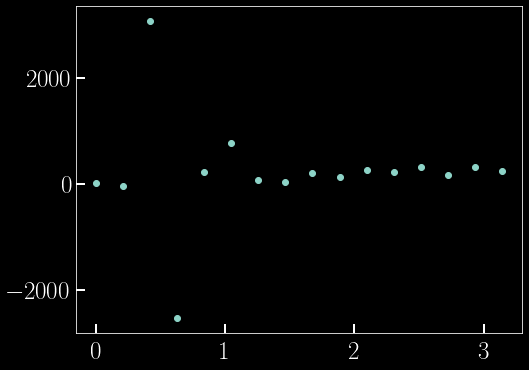

In [202]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(angLC, qlc, ls = 'none', marker = 'o');
#ax.set_ylim(-2.5e-8, 3n.5e-8);

In [204]:
mbg, embg = bootstrap(BsG, 10000)

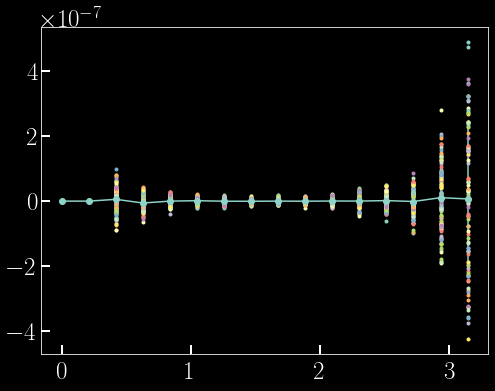

In [209]:
fig, ax = plt.subplots(figsize = (8, 6))
#ax.set_xscale('log')
#ax.set_yscale('log')
for bg in BsG :
    ax.errorbar(angRG, bg, ls = 'none', marker = '.');
ax.errorbar(angRG, mbg, embg, marker = 'o');

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_xscale('log')
#ax.set_yscale('log')
for bg in BsG :
    ax.errorbar(angRG, bg, ls = 'none', marker = '.');
ax.errorbar(angRG, mbg, embg, marker = 'o');

In [95]:
PP, ePP = bootstrap(PsLC, 1000)

In [182]:
B1s, B2s, B3s, QEQs, QORs = [], [], [], [], []
for pslc in PsLC :
    B1s.append(pslc[0] * pslc[1] + pslc[1] * pslc[2:] + pslc[2:] * pslc[0])
    B2s.append(pslc[0] ** (1./3.) * pslc[1] ** (2./3.) * pslc[2:] + pslc[2:] ** (1./3.) * pslc[0] ** (2./3.) * pslc[1] + pslc[1] ** (1./3.) * pslc[2:] ** (2./3.) * pslc[0])
    B3s.append((pslc[0] * pslc[1] * pslc[2:]) ** (2./3.))
    QEQs.append((-1. + (B2s[-1] - 2. * B3s[-1]) / B1s[-1]))
    QORs.append((-3. + (3. * B2s[-1] - 8. * B3s[-1]) / B1s[-1]))
B1s = np.array(B1s)
B2s = np.array(B2s)
B3s = np.array(B3s)
QEQs = np.array(QEQs)
QORs = np.array(QORs)
b1, eb1 = bootstrap(B1s, 10000)
b2, eb2 = bootstrap(B2s, 10000)
b3, eb3 = bootstrap(B3s, 10000)
qeq, eqeq = bootstrap(QEQs, 10000)
qor, eqor = bootstrap(QORs, 10000)

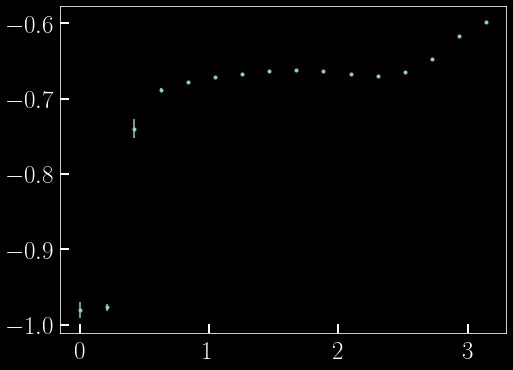

In [187]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.errorbar(angEQ, qeq, eqeq, ls = 'none', marker = '.');

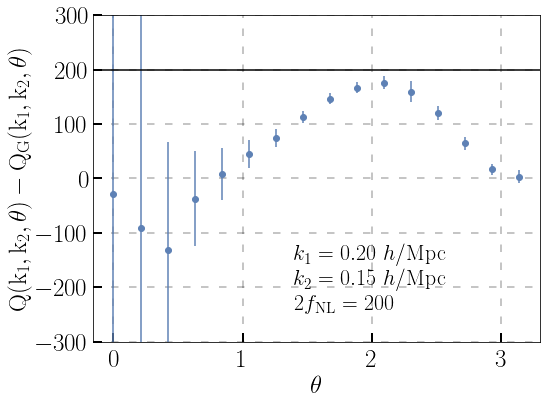

In [157]:
with userc() :
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.errorbar(angEQ, dqEQ, edqEQ, ls = 'none', marker = 'o')
    #ax.plot(angEQ, QEQ(100., 0.2, 0.15, angEQ))
    ax.text(0.45,0.10, '$k_1 = ' + '%.2f' % (0.2) + '\ h/\mathrm{Mpc}$' + '\n' + '$k_2 = ' + '%.2f' % (0.15) + '\ h/\mathrm{Mpc}$' + '\n' + '$2f_{\mathrm{NL}}=200$', fontsize = 22, transform = ax.transAxes);
    ax.axhline(200., color = 'black');
    ax.grid(dashes = (5, 7), color = 'black')
    ax.set_ylim(-300, 300)
    ax.set_ylabel(r'$\mathrm{Q(k_1, k_2, \theta) - Q_{\mathrm{G}}(k_1, k_2, \theta)}$');
    ax.set_xlabel(r'$\theta$');

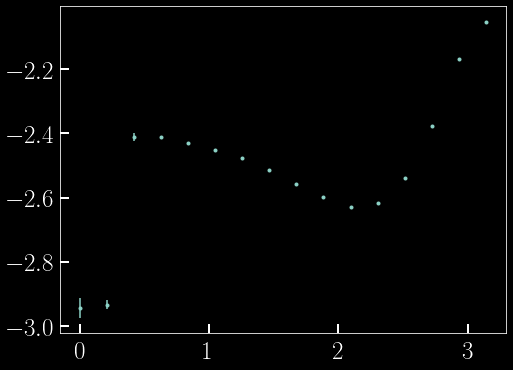

In [188]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.errorbar(angOR, qor, eqor, ls = 'none', marker = '.');

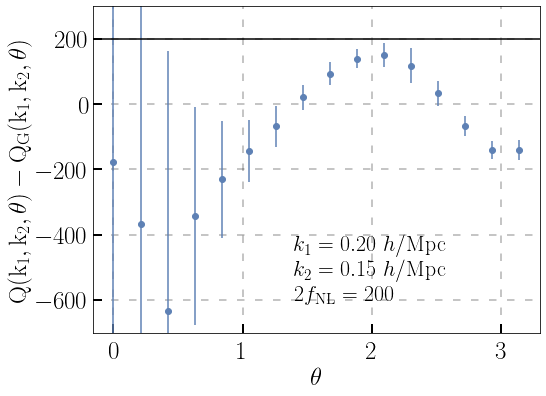

In [189]:
with userc() :
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.errorbar(angOR, dqOR, edqOR, ls = 'none', marker = 'o')
    ax.text(0.45, 0.10, '$k_1 = ' + '%.2f' % (0.2) + '\ h/\mathrm{Mpc}$' + '\n' + '$k_2 = ' + '%.2f' % (0.15) + '\ h/\mathrm{Mpc}$' + '\n' + '$2f_{\mathrm{NL}}=200$', fontsize = 22, transform = ax.transAxes);
    ax.axhline(200., color = 'black');
    ax.grid(dashes = (5, 7), color = 'black')
    ax.set_ylim(-700, 300)
    ax.set_ylabel(r'$\mathrm{Q(k_1, k_2, \theta) - Q_{\mathrm{G}}(k_1, k_2, \theta)}$');
    ax.set_xlabel(r'$\theta$');
    #plt.savefig('fNL_test_Roman.png', dpi = 200, facecolor = 'white', bbox_inches = 'tight');

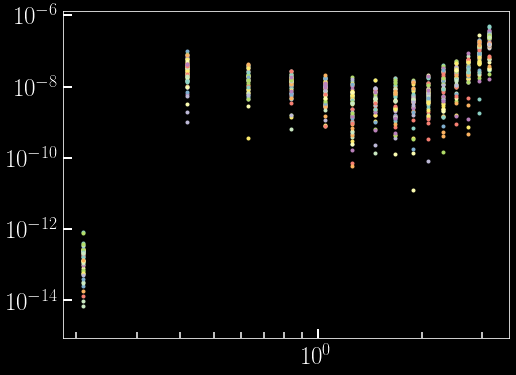

In [137]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_xscale('log')
ax.set_yscale('log')

#ax.errorbar(angLC, PP[0] * PP[1] + PP[1] * PP[2:] + PP[2:] * PP[0], ls = 'none', marker = '.')
for bg in BsG :
    ax.errorbar(angRG, bg, ls = 'none', marker = '.');

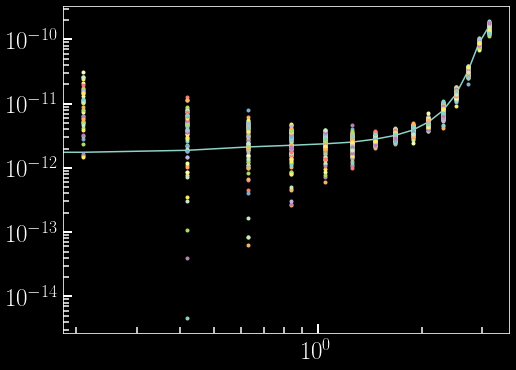

In [142]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(angLC, PP[0] * PP[1] + PP[1] * PP[2:] + PP[2:] * PP[0])
for blc, bg in zip(BsLC, BsG) :
    ax.errorbar(angLC, (blc - bg) / 200., ls = 'none', marker = '.');
#ax.plot(kk, pp_B)

#ax.set_xlim(4.e-2, 7.e-1)
#ax.set_ylim(5.e-8, 9.e-4);

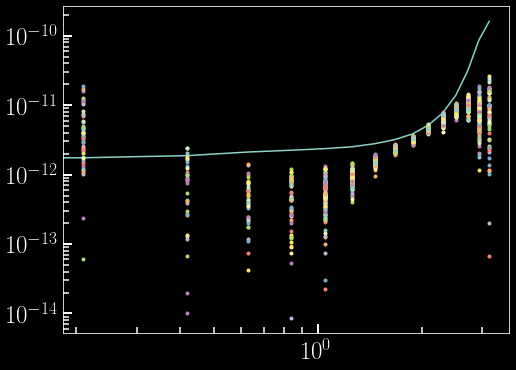

In [143]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(angLC, PP[0] * PP[1] + PP[1] * PP[2:] + PP[2:] * PP[0])
for beq, bg in zip(BsEQ, BsG) :
    ax.errorbar(angEQ, (beq - bg) / 200., ls = 'none', marker = '.');

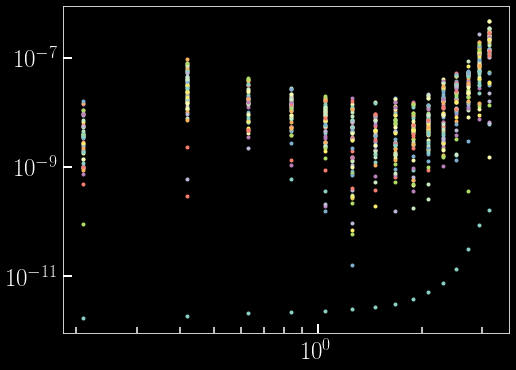

In [139]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(angLC, PP[0] * PP[1] + PP[1] * PP[2:] + PP[2:] * PP[0], ls = 'none', marker = '.')
for bor in BsOR :
    ax.errorbar(angOR, bor, ls = 'none', marker = '.');
#ax.plot(kk, pp_B)

#ax.set_xlim(4.e-2, 7.e-1)
#ax.set_ylim(5.e-8, 9.e-4);

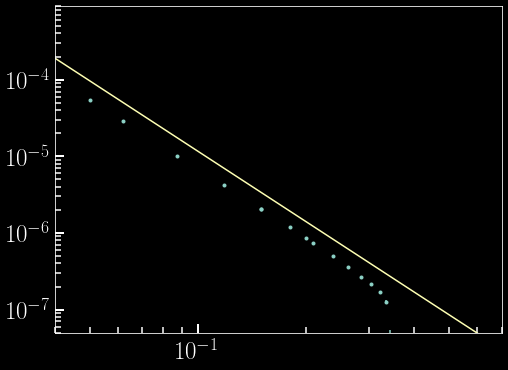

In [104]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kLC, PP, ePP, ls = 'none', marker = '.')
ax.plot(kk, pp_B)

ax.set_xlim(4.e-2, 7.e-1)
ax.set_ylim(5.e-8, 9.e-4);


In [ ]:
dqLC, edqLC = bootstrap(np.array(QsLC) - np.array(QsRG), 1000)
dqEQ, edqEQ = bootstrap(np.array(QsEQ) - np.array(QsRG), 1000)
dqOR, edqOR = bootstrap(np.array(QsOR) - np.array(QsRG), 1000)

In [67]:
BLC, eBLC = bootstrap(np.array(QsLC) - np.array(QsG), 1000)

<ErrorbarContainer object of 3 artists>

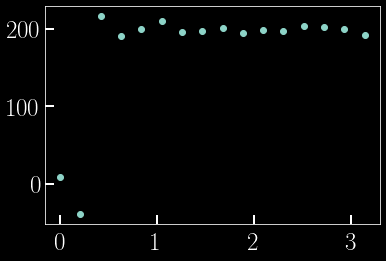

In [69]:
plt.errorbar(angLC, BLC, ls = 'none', marker = 'o')

In [70]:
BEQ, eBEQ = bootstrap(np.array(QsEQ) - np.array(QsG), 1000)

<ErrorbarContainer object of 3 artists>

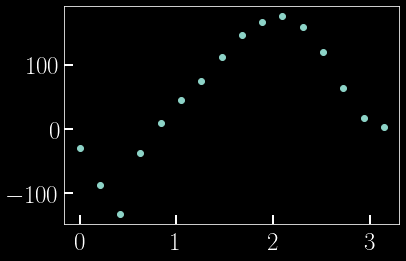

In [73]:
plt.errorbar(angEQ, BEQ, ls = 'none', marker = 'o')

In [84]:
BOR, eBOR = bootstrap(np.array(BsOR) - np.array(BsG), 1000)

<ErrorbarContainer object of 3 artists>

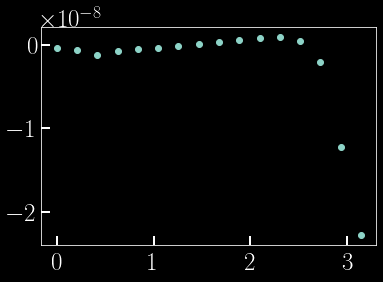

In [85]:
plt.errorbar(angEQ, BOR, ls = 'none', marker = 'o')

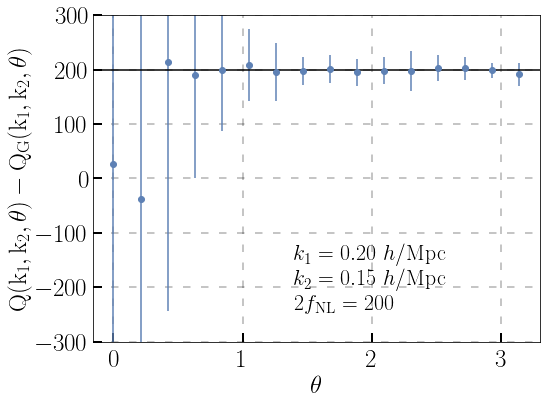

In [25]:
with userc() :
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.errorbar(angLC, dqLC, edqLC, ls = 'none', marker = 'o')
    ax.text(0.45, 0.10, '$k_1 = ' + '%.2f' % (0.2) + '\ h/\mathrm{Mpc}$' + '\n' + '$k_2 = ' + '%.2f' % (0.15) + '\ h/\mathrm{Mpc}$' + '\n' + '$2f_{\mathrm{NL}}=200$', fontsize = 22, transform = ax.transAxes);
    ax.axhline(200., color = 'black');
    ax.grid(dashes = (5, 7), color = 'black')
    ax.set_ylim(-300, 300)
    ax.set_ylabel(r'$\mathrm{Q(k_1, k_2, \theta) - Q_{\mathrm{G}}(k_1, k_2, \theta)}$');
    ax.set_xlabel(r'$\theta$');
    #plt.savefig('fNL_test_Roman.png', dpi = 200, facecolor = 'white', bbox_inches = 'tight');

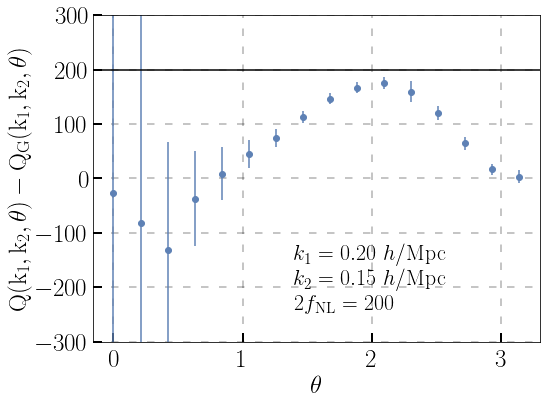

In [26]:
with userc() :
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.errorbar(angEQ, dqEQ, edqEQ, ls = 'none', marker = 'o')
    ax.plot(angEQ, QEQ(100., 0.2, 0.15, angEQ))
    ax.text(0.45,0.10, '$k_1 = ' + '%.2f' % (0.2) + '\ h/\mathrm{Mpc}$' + '\n' + '$k_2 = ' + '%.2f' % (0.15) + '\ h/\mathrm{Mpc}$' + '\n' + '$2f_{\mathrm{NL}}=200$', fontsize = 22, transform = ax.transAxes);
    ax.axhline(200., color = 'black');
    ax.grid(dashes = (5, 7), color = 'black')
    ax.set_ylim(-300, 300)
    ax.set_ylabel(r'$\mathrm{Q(k_1, k_2, \theta) - Q_{\mathrm{G}}(k_1, k_2, \theta)}$');
    ax.set_xlabel(r'$\theta$');
    #plt.savefig('fNL_test_Roman.png', dpi = 200, facecolor = 'white', bbox_inches = 'tight');

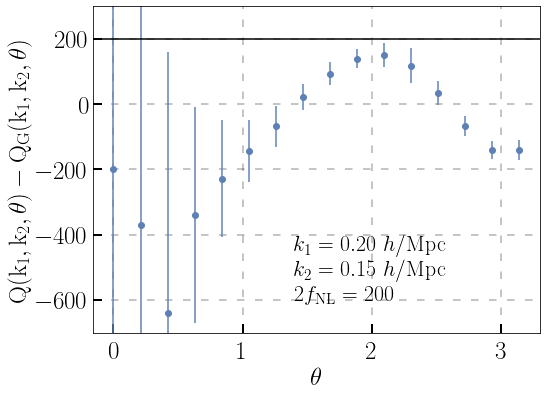

In [27]:
with userc() :
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.errorbar(angOR, dqOR, edqOR, ls = 'none', marker = 'o')
    ax.plot(angOR, -QOR(100., 0.2, 0.15, angOR))
    ax.text(0.45, 0.10, '$k_1 = ' + '%.2f' % (0.2) + '\ h/\mathrm{Mpc}$' + '\n' + '$k_2 = ' + '%.2f' % (0.15) + '\ h/\mathrm{Mpc}$' + '\n' + '$2f_{\mathrm{NL}}=200$', fontsize = 22, transform = ax.transAxes);
    ax.axhline(200., color = 'black');
    ax.grid(dashes = (5, 7), color = 'black')
    ax.set_ylim(-700, 300)
    ax.set_ylabel(r'$\mathrm{Q(k_1, k_2, \theta) - Q_{\mathrm{G}}(k_1, k_2, \theta)}$');
    ax.set_xlabel(r'$\theta$');
    #plt.savefig('fNL_test_Roman.png', dpi = 200, facecolor = 'white', bbox_inches = 'tight');

In [30]:
def QEQ(fNL, k1, k2, theta) :
    k3 = 
    P1 = P(k1)
    P2 = P(k2)
    P3 = P(k3)
    D = (P1 * P2 + P2 * P3 + P3 * P1)
    A = (P1 * P2 * P3) ** (2. / 3.) / D
    B = (P1 **(1./3.) * P2 ** (2./3.) * P3 + P2 **(1./3.) * P3 ** (2./3.) * P1 + P3 **(1./3.) * P1 ** (2./3.) * P2) / D
    return -6. * fNL * (1. + 2. * A - B)

def QOR(fNL, k1, k2, theta) :
    k3 = 
    P1 = P(k1)
    P2 = P(k2)
    P3 = P(k3)
    D = (P1 * P2 + P2 * P3 + P3 * P1)
    A = (P1 * P2 * P3) ** (2. / 3.) / D
    B = (P1 **(1./3.) * P2 ** (2./3.) * P3 + P2 **(1./3.) * P3 ** (2./3.) * P1 + P3 **(1./3.) * P1 ** (2./3.) * P2) / D
    return -6. * fNL * (3. + 8. * A - 3. * B)

SyntaxError: invalid syntax (<ipython-input-30-ad12c07a74f6>, line 2)

In [32]:
write_file('lc.dat', [angLC, dqLC, edqLC, kLC])
write_file('eq.dat', [angEQ, dqEQ, edqEQ, kEQ])
write_file('or.dat', [angOR, dqOR, edqOR, kOR])

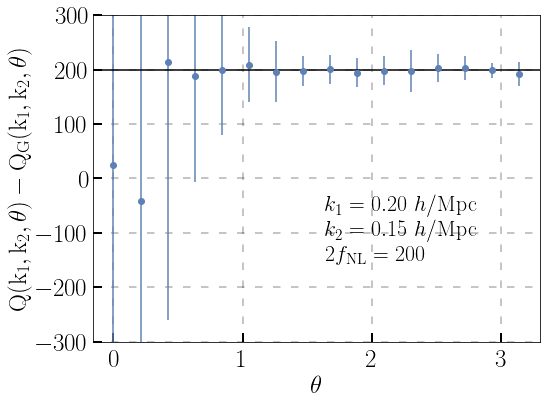

In [176]:
with userc() :
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.errorbar(ang, qqqR, eqqqR, ls = 'none', marker = 'o')
    ax.text(0.52,0.25, '$k_1 = ' + '%.2f' % (0.2) + '\ h/\mathrm{Mpc}$' + '\n' + '$k_2 = ' + '%.2f' % (0.15) + '\ h/\mathrm{Mpc}$' + '\n' + '$2f_{\mathrm{NL}}=200$', fontsize = 22, transform = ax.transAxes);
    ax.axhline(200., color = 'black');
    ax.grid(dashes = (5, 7), color = 'black')
    ax.set_ylim(-300, 300)
    ax.set_ylabel(r'$\mathrm{Q(k_1, k_2, \theta) - Q_{\mathrm{G}}(k_1, k_2, \theta)}$');
    ax.set_xlabel(r'$\theta$');
    plt.savefig('fNL_test_Roman.png', dpi = 200, facecolor = 'white', bbox_inches = 'tight');


Computing bispectrum of the field...
Time to compute bispectrum = 0.70

Computing bispectrum of the field...
Time to compute bispectrum = 0.70

Computing bispectrum of the field...
Time to compute bispectrum = 0.71

Computing bispectrum of the field...
Time to compute bispectrum = 0.74

Computing bispectrum of the field...
Time to compute bispectrum = 0.73

Computing bispectrum of the field...
Time to compute bispectrum = 0.73

Computing bispectrum of the field...
Time to compute bispectrum = 0.72

Computing bispectrum of the field...
Time to compute bispectrum = 0.72

Computing bispectrum of the field...
Time to compute bispectrum = 0.71

Computing bispectrum of the field...
Time to compute bispectrum = 0.74

Computing bispectrum of the field...
Time to compute bispectrum = 0.72

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.71

Computing bispectrum of the field...
Time to compute bispectrum

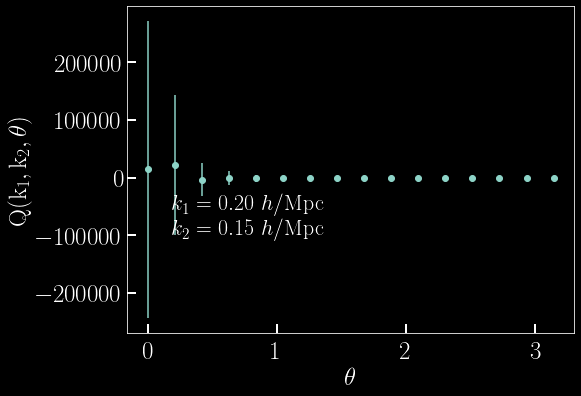

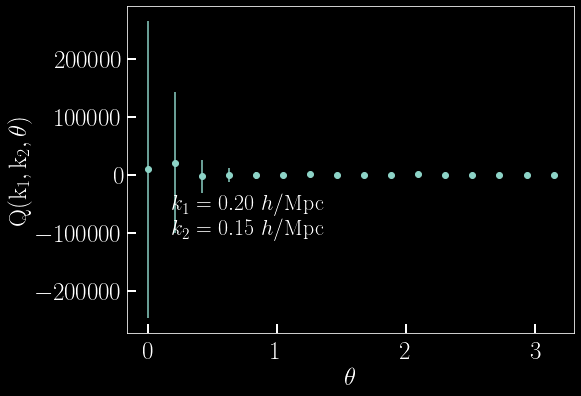

In [170]:
angG, kG, qqG, eqqG, QGs = plotQ('../Meshes/bardeen_potential_G', 100, 2.e3, 128, 0.2, 0.15)
ang, k, qq, eqq, Qs = plotQ('../Meshes/bardeen_potential_NG', 100, 2.e3, 128, 0.2, 0.15)
qqq, eqqq = bootstrap(np.array(Qs) - np.array(QGs), 1000)

In [ ]:
with userc() :
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.errorbar(ang, qqqR, eqqqR, ls = 'none', marker = 'o')
    ax.text(0.52,0.25, '$k_1 = ' + '%.2f' % (0.2) + '\ h/\mathrm{Mpc}$' + '\n' + '$k_2 = ' + '%.2f' % (0.15) + '\ h/\mathrm{Mpc}$' + '\n' + '$2f_{\mathrm{NL}}=200$', fontsize = 22, transform = ax.transAxes);
    ax.axhline(200., color = 'black');
    ax.grid(dashes = (5, 7), color = 'black')
    ax.set_ylim(-300, 300)
    ax.set_ylabel(r'$\mathrm{Q(k_1, k_2, \theta) - Q_{\mathrm{G}}(k_1, k_2, \theta)}$');
    ax.set_xlabel(r'$\theta$');
    plt.savefig('fNL_test_Roman.png', dpi = 200, facecolor = 'white', bbox_inches = 'tight');

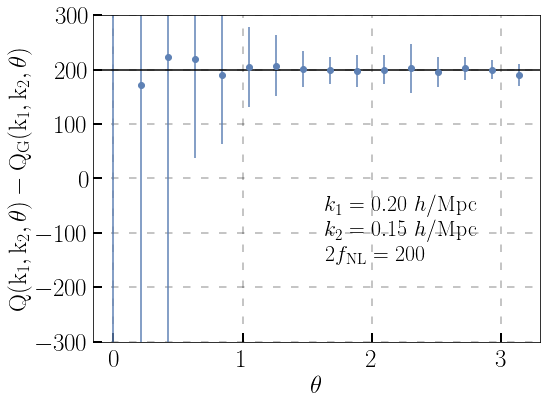

In [175]:
with userc() :
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.errorbar(ang, qqq, eqqq, ls = 'none', marker = 'o')
    ax.text(0.52,0.25, '$k_1 = ' + '%.2f' % (0.2) + '\ h/\mathrm{Mpc}$' + '\n' + '$k_2 = ' + '%.2f' % (0.15) + '\ h/\mathrm{Mpc}$' + '\n' + '$2f_{\mathrm{NL}}=200$', fontsize = 22, transform = ax.transAxes);
    ax.axhline(200., color = 'black');
    ax.grid(dashes = (5, 7), color = 'black')
    ax.set_ylim(-300, 300)
    ax.set_ylabel(r'$\mathrm{Q(k_1, k_2, \theta) - Q_{\mathrm{G}}(k_1, k_2, \theta)}$');
    ax.set_xlabel(r'$\theta$');
    plt.savefig('fNL_test_LD.png', dpi = 200, facecolor = 'white', bbox_inches = 'tight');

In [108]:
def plotQ(fn) :
    
    Qks = []
    
    for i in range(21) :
        mesh = np.array(np.reshape(load_file('../Meshes/%s_NG_%02d.dat' % (fn, i), 1, np.float64), (128, 128, 128)), dtype = np.float32)
    
        BoxSize = 1.0e3 #Size of the density field in Mpc/h
        k1      = 0.02    #h/Mpc
        k2      = 0.05    #h/Mpc
        MAS     = 'CIC'
        threads = 28
        theta   = np.linspace(0, np.pi, 32) #array with the angles between k1 and k2

        # compute bispectrum
        B = PKL.Bk(mesh, BoxSize, k1, k2, theta, 'None', threads)
        Bk = B.B     #bispectrum
        Qks.append(B.Q)     #reduced bispectrum
        k  = B.k     #k-bins for power spectrum
        Pk = B.Pk    #power spectrum        
    qq, eqq = bootstrap(Qks, 1000)

    fig, ax = plt.subplots(figsize = (8, 6))
    ax.errorbar(theta, qq, eqq, ls = 'none', marker = 'o')
    ax.text(0.1,0.3, '$k_1 = 0.02\ h/\mathrm{Mpc}$' + '\n' + '$k_2 = 0.05\ h/\mathrm{Mpc}$', fontsize = 22, transform = ax.transAxes);
    ax.set_ylabel(r'$\mathrm{Q(k_1, k_2, \theta)}$');
    ax.set_xlabel(r'$\theta$');
    return k, qq, eqq

In [31]:
def k3(t_k1, t_k2, t_theta):
    return np.sqrt(t_k1 ** 2 + t_k2 ** 2 + 2. * t_k1 * t_k2 * np.cos(t_theta))
pk = interp1d(k, Pk, fill_value = 'extrapolate')

NameError: name 'k' is not defined

In [97]:
np.savetxt('seeds.txt', np.random.randint(2 ** (32 - 1) - 1, size = 100, dtype = np.int32), fmt = '%d')

In [212]:
127 + (128 / 2 + 1) * (127 + 128 * 127) 

127.50019892500644

In [211]:
2128943

2128943

In [214]:
(128 / 2 + 1) * 128 * 128 / 

1.9980487804878049

In [215]:
2128943 / 1064960

1.9990825946514423

In [8]:
class Bispectrum(object) :
    def __init__(self, fn) :
        kins, pins, self.k3, self.theta, self.b, self.p3, self.nm = load_file(fn, 7)
        self.k1, self.k2 = kins
        self.p1, self.p2 = pins
        self.blc = self.p1 * self.p2 + self.p2 * self.p3 + self.p3 * self.p1
        self.q = self.b / self.blc
        self.bA = self.p1 ** (1./3.) * self.p2 ** (2./3.) * self.p3 + self.p2 ** (1./3.) * self.p3 ** (2./3.) * self.p1 + self.p3 ** (1./3.) * self.p1 ** (2./3.) * self.p2
        self.bB = (self.p1 * self.p2 * self.p3) ** (2./3.)
        self.qeq = -1. + (self.bA - 2. * self.bB) / self.blc
        self.qor = -3. + (3. * self.bA - 8. * self.bB) / self.blc

In [254]:
qq = []
for i in range(100) :
    test_bs = Bispectrum('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/bispectra/LC/bispectrum_Phi_LC_k2.00e-01_k1.50e-01_%d.dat' % (i))
    qq.append(test_bs.q)
mqq, emqq = bootstrap(qq, 1000)

In [9]:
test_bs = Bispectrum('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/bispectra/LC/bispectrum_Phi_LC_k2.00e-01_k1.50e-01_0.dat')

<ipython-input-10-b52a32cb52d9>:2: RuntimeWarning: divide by zero encountered in power
  plt.loglog(test_bs.k3, 1.e-8 * test_bs.k3 ** -3)


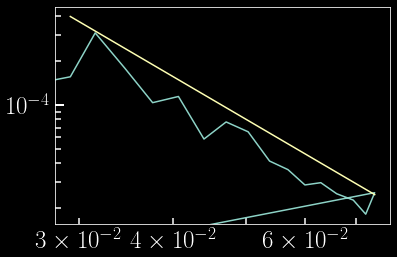

In [10]:
plt.loglog(test_bs.k3, test_bs.p3)
plt.loglog(test_bs.k3, 1.e-8 * test_bs.k3 ** -3)

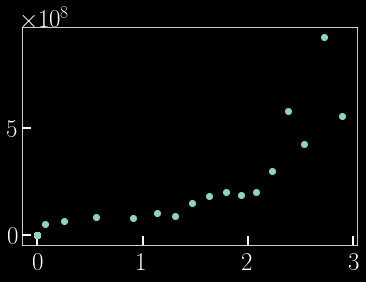

In [11]:
plt.plot(test_bs.theta, test_bs.b, ls = 'none', marker = 'o');

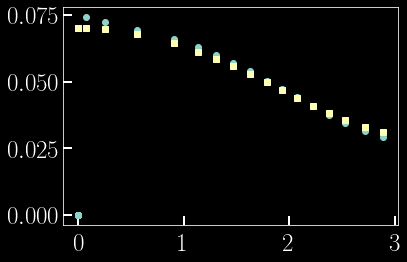

In [12]:
plt.plot(test_bs.theta, test_bs.k3, ls = 'none', marker = 'o');
plt.plot(test_bs.theta, np.sqrt(test_bs.k1 ** 2 + test_bs.k2 ** 2 + 2. * test_bs.k1 * test_bs.k2 * np.cos(test_bs.theta)), ls = 'none', marker = 's');

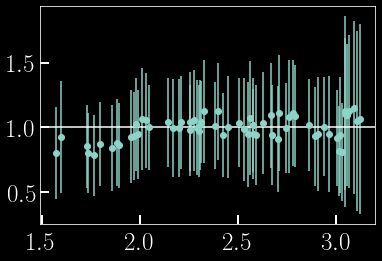

In [264]:
plt.errorbar(test_bs.theta, mqq  / test_bs.theta / (2.e3)**3 / 200. / 4. / 1.25, emqq  / test_bs.theta / (2.e3)**3 / 200. / 4., ls = 'none', marker = 'o');
plt.axhline(1.);

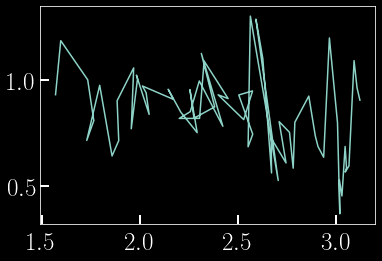

In [252]:
plt.plot(test_bs.theta, test_bs.q / test_bs.theta**2 / (2.e3)**3 / 200. / 2.);

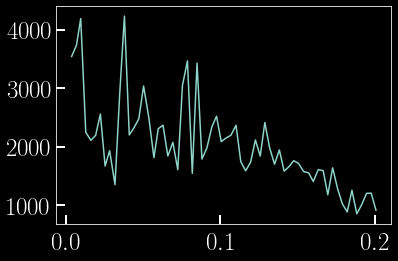

In [246]:
plt.plot(test_bs.k3, test_bs.q / (2.e3)**3);

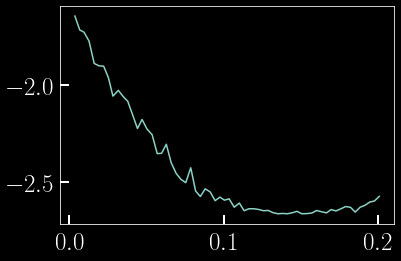

In [247]:
plt.plot(test_bs.k3, test_bs.qor);

In [314]:
def get3from1(ii) :
    i = int(np.floor(ii / 65 / 128))
    j = int(np.floor((ii / 65 ) % 128))
    k = int(ii % 65)
    return i, j, k

def getsigned3from1(ii) :
    i = int(np.floor(ii / 65 / 128))
    j = int(np.floor((ii / 65 ) % 128))
    k = int(ii % 65)
    if i > 64 :
        i = i - 128
    if j > 64 :
        j = j -  128
    if k > 64 :
        k = k - 128
    return i, j, k

In [313]:
get3from1(915261)

(110, 0, 61)

In [315]:
getsigned3from1(915261)

(-18, 0, 61)

In [316]:
getsigned3from1(915244)

(-18, 0, 44)

In [318]:
-(61 + 44)

-105

In [319]:
128 - 36

92

In [320]:
128. - 105

23.0

In [321]:
128. - 23

105.0

In [346]:
np.pi / 2.e3 * 64

0.10053096491487339

In [375]:
meshG = load_file('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/Meshes/G/roman_bp_G_0.dat', 1, np.float64)
meshLC = load_file('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/Meshes/LC/roman_bp_NG_0.dat', 1, np.float64)
meshEQ = load_file('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/Meshes/EQ/roman_bp_NG_0.dat', 1, np.float64)
meshOR = load_file('/mnt/home/ajamieson/ceph/Software/Source/Roman_2LPT_PNGnonlocal/Meshes/OR/roman_bp_NG_0.dat', 1, np.float64)

In [376]:
xG, yG = histogram(mesh, 50)
xLC, yLC = histogram(meshLC, 50)
xEQ, yEQ = histogram(meshEQ, 50)
xOR, yOR = histogram(meshOR, 50)

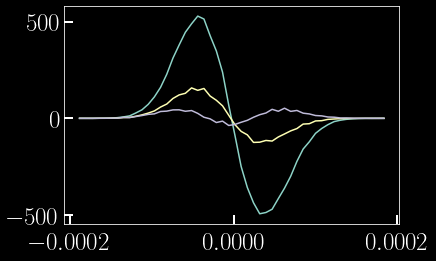

In [377]:
plt.plot(x, yNG - y)
plt.plot(x, yEQ - y)
plt.plot(x, yOR - y)